### 0. Импорты и иннициализация

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
from utils.shortcuts import print_deep_mem_usage

In [3]:
# Настройка форматов
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format',  '{:,.2f}'.format)

sns.set_theme(style="whitegrid")
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = (10,4)
plt.rcParams['axes.titlesize'] = 'large'
plt.rcParams['axes.labelsize'] =  'medium'
plt.rcParams['xtick.labelsize'] =  'small'
plt.rcParams['ytick.labelsize'] =  'small'
plt.rcParams['legend.title_fontsize'] = 'medium'
plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['legend.framealpha'] = .9

### 1. Загрузка данных из .csv

In [4]:
category_tree = pd.read_csv('../data/category_tree.csv')
events = pd.read_csv('../data/events.csv')
items1 = pd.read_csv('../data/item_properties_part1.csv')
items2 = pd.read_csv('../data/item_properties_part2.csv')

In [5]:
# Оъедияем items в одну таблицу
items = pd.concat([items1, items2])
del items1, items2

### 2. Дерево категорий (category_tree.csv)

In [6]:
# Визуальный осмотр
category_tree.head(3)

,categoryid,parentid
0,1016,213.00
1,809,169.00
2,570,9.00


In [7]:
# Переименуем столбцы из эстетических соображений
category_tree = category_tree.rename(columns={'categoryid': 'category_id',
                                              'parentid': 'parent_id'})

In [8]:
category_tree.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1669 entries, 0 to 1668
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   category_id  1669 non-null   int64  
 1   parent_id    1644 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 26.2 KB


In [9]:
# Проверям отсутствие дубликатов по category_id
category_tree['category_id'].duplicated().sum()

np.int64(0)

Присутствуют пропуски в parent_id -> судя по всему это категории 'верхнего' уровня.  

__NB: приимем, что дерево категорий у нас растет сверху вниз (!)__

In [10]:
# Количество категорий верхнего уровня
print(f"Top-level categories: {category_tree['parent_id'].isna().sum()}")

Top-level categories: 25


Для каждой категории найдем всех её 'родителей' и добавим соответствующий перечень в столбец `parents`.


In [11]:
# Создаем пустой столбец 'parents'
category_tree['parents'] = pd.NA

# Получим содержимое таблицы в виде списка кортежей (category_id, parent_id)
categories = list(category_tree[['category_id', 'parent_id']]
                  .itertuples(index=False))

# Временно поменяем индекс таблицы на 'category_id'
category_tree.set_index('category_id', inplace=True)

# Итерируем, пока в списке кортежей есть элементы (необработанне категории)
while(categories_left := len(categories)):

    # Проходим по копии (!) списка необработанных категорий
    for category_id, parent_id in list(categories):
        
        # Если категория не является категорией верхнего уровня
        # И ее родительская категория еще не обработана (не размечена в таблице)
        # переходим к следующей
        if (
            pd.notna(parent_id) 
            and parent_id not in (
               category_tree[category_tree['parents'].notna()].index
            )
        ):
            continue

        # Для всех категорий, кроме верхнего уровня, список родителей это:
        # родители родителя плюс сам родитель :)
        # А для верхнего уровня список родителей пустой.
        category_tree.at[category_id, 'parents'] = (
            category_tree.at[parent_id, 'parents'] + [int(parent_id)]
            if pd.notna(parent_id) else []
        )
            
        # Удаляем категорию из списка необработанных 
        categories.pop(categories.index((category_id, parent_id)))

    # Если после прохода число категорий в списке не уменьшилось
    # то прерываем цикл (битые данные: категории с неизвестными parent_id) 
    if len(categories) == categories_left:
        break

# Возвращаем 'category_id' обратно в столбцы 
category_tree.reset_index(inplace=True)

# Перепакуем списки в кортежи
category_tree['parents'] = category_tree['parents'].map(
    lambda x: tuple(x) if isinstance(x, list) else x
)

# Проверяем, все ли категории обработали:
print(f'Orphan categories: {categories}')

# Визуальная проверка результата
category_tree.head(3)

Orphan categories: []


,category_id,parent_id,parents
0,1016,213.00,"(1532, 1299, 213)"
1,809,169.00,"(395, 1257, 169)"
2,570,9.00,"(653, 351, 9)"


Для удобства анализа рассчитаем и добавим в таблицу дополнительные признаки:  
- _`cat_level`_ - уровень категории: 1 - для 'верхнего' уровня, 2 - для следующего и т.д.
- _`has_subcat`_ - имеет ли категория дочерние (под)категории или же находится на самом 'нижнем' уровне дерева.
- _`top_cat_id`_ - идентификатор категории верхнего уровня, к которой относится данная категория. 

In [12]:
# Добавляем дополнительные признаки
category_tree['cat_level'] = category_tree['parents'].map(lambda x: len(x) + 1)
category_tree['has_subcat'] = category_tree['category_id'].isin(
    category_tree['parents'].explode().drop_duplicates()
)
category_tree['top_cat_id'] = (
    category_tree[['category_id', 'parents']]
    .apply(lambda x: x.parents[0] if x.parents else x.category_id, axis=1)
)

# Визуальная проверка
category_tree.tail(3)

,category_id,parent_id,parents,cat_level,has_subcat,top_cat_id
1666,1336,745.00,"(140, 540, 745)",4,False,140
1667,689,207.00,"(1490, 207)",3,False,1490
1668,761,395.00,"(395,)",2,False,395


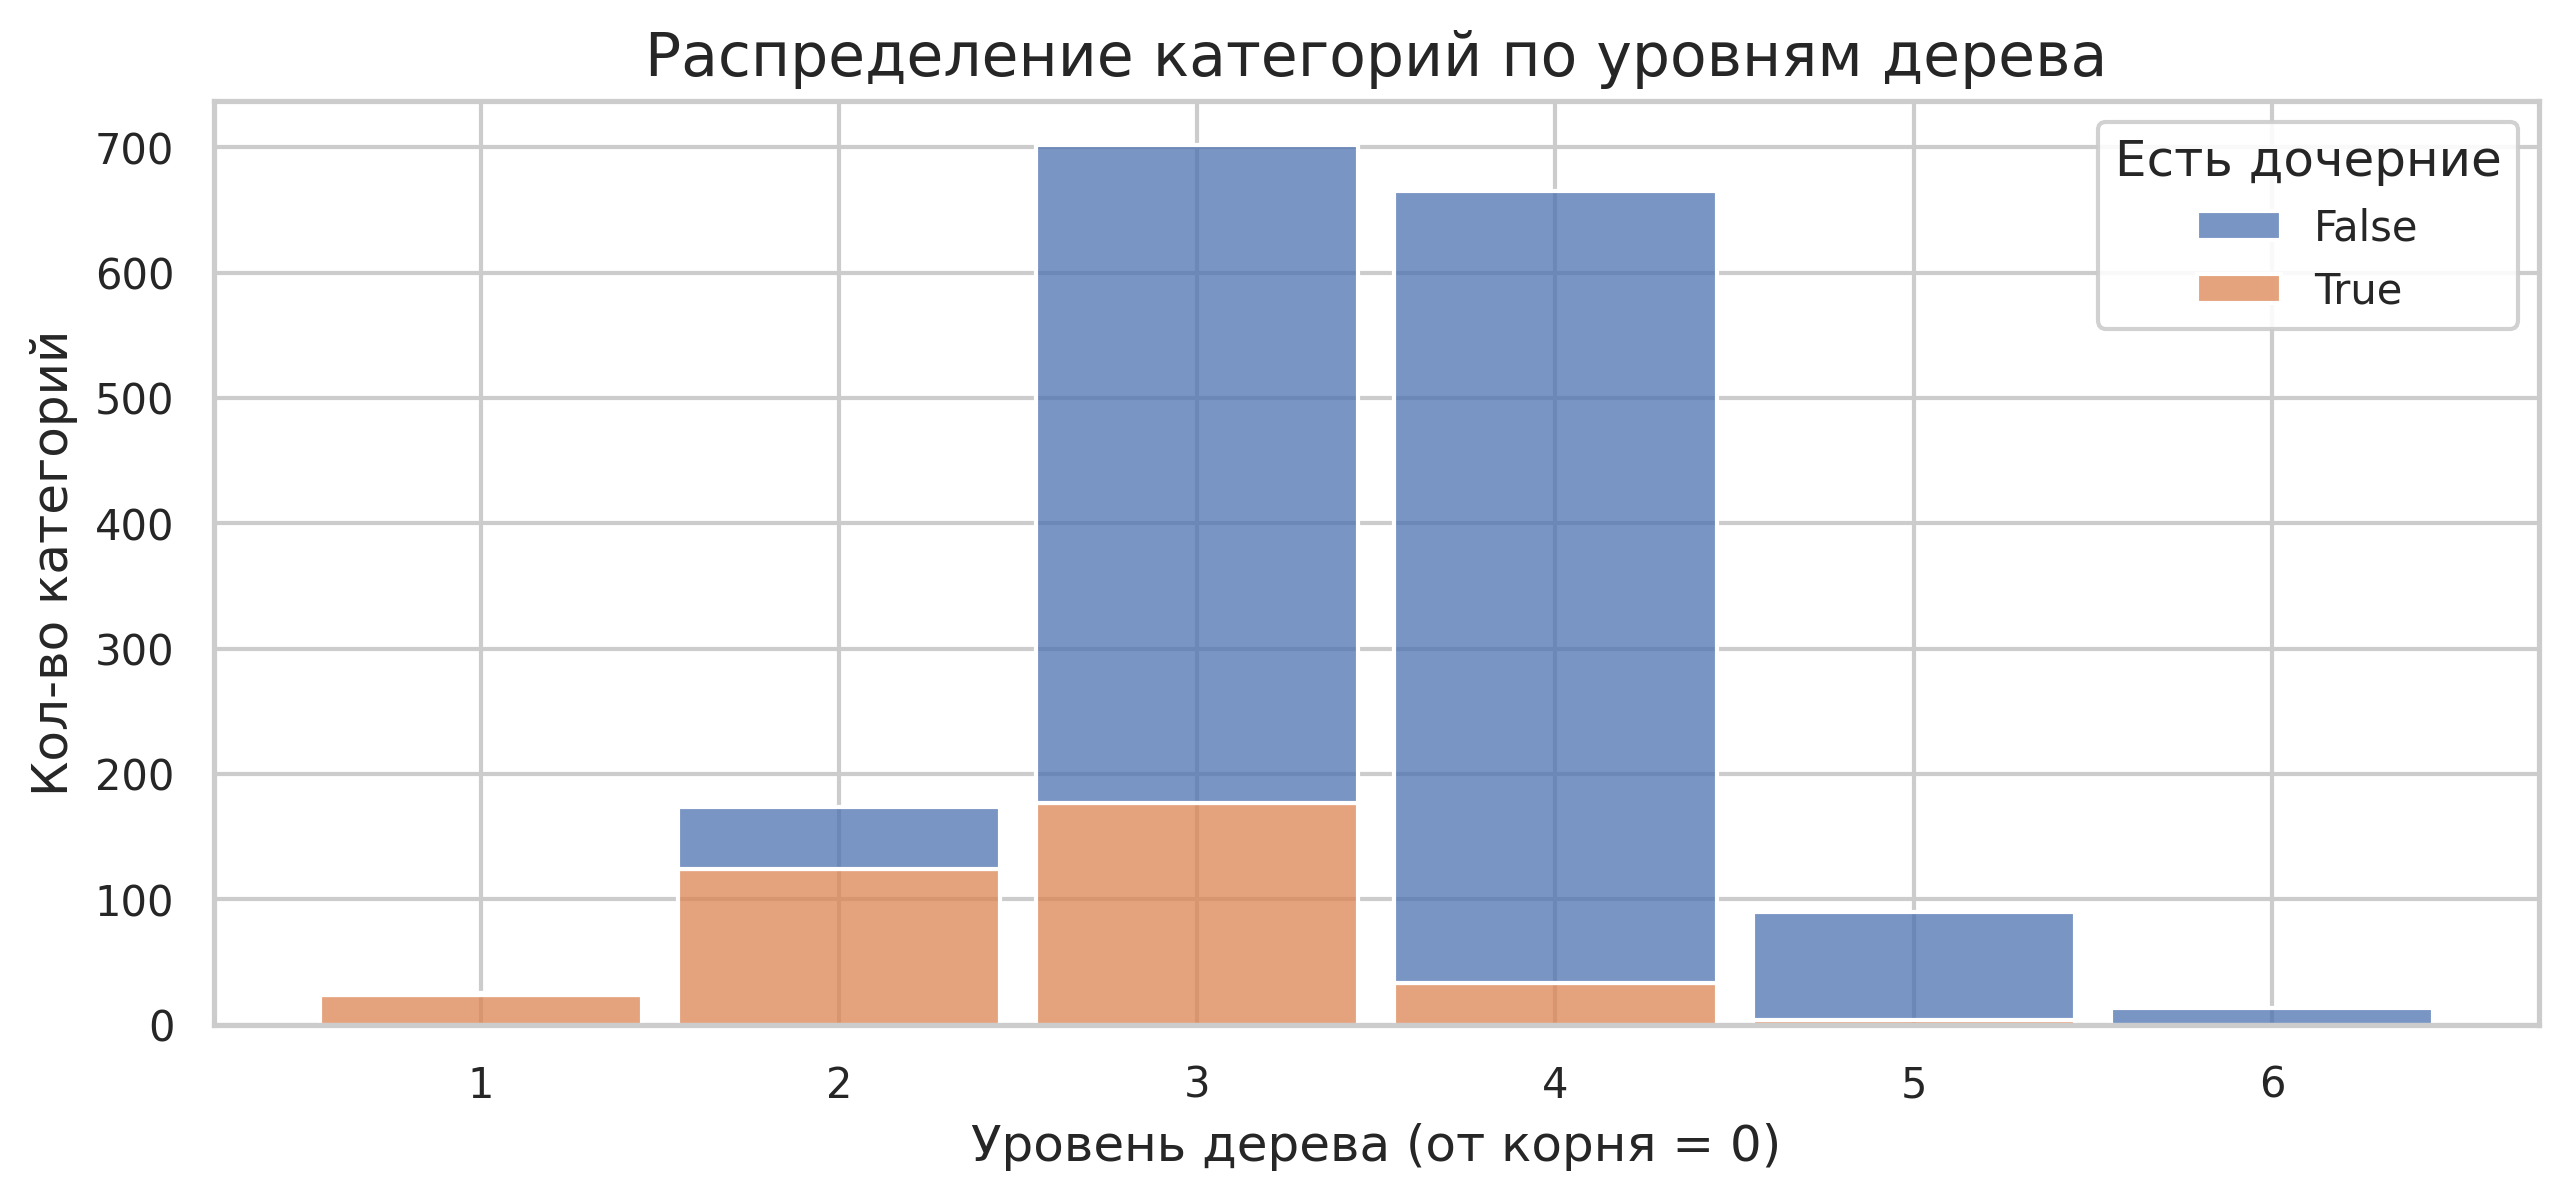

In [13]:
# Визуализируем распределние категорий по уровням
plt.rcParams['figure.figsize'] = (10,4)
ax = sns.histplot(
    category_tree,
    x='cat_level',
    hue='has_subcat',
    multiple='stack',
    discrete=True, 
    shrink=.9
)
ax.get_legend().set_title('Есть дочерние')
ax.set_xlabel('Уровень дерева (от корня = 0)')
ax.set_ylabel('Кол-во категорий')
ax.set_title('Распределение категорий по уровням дерева');

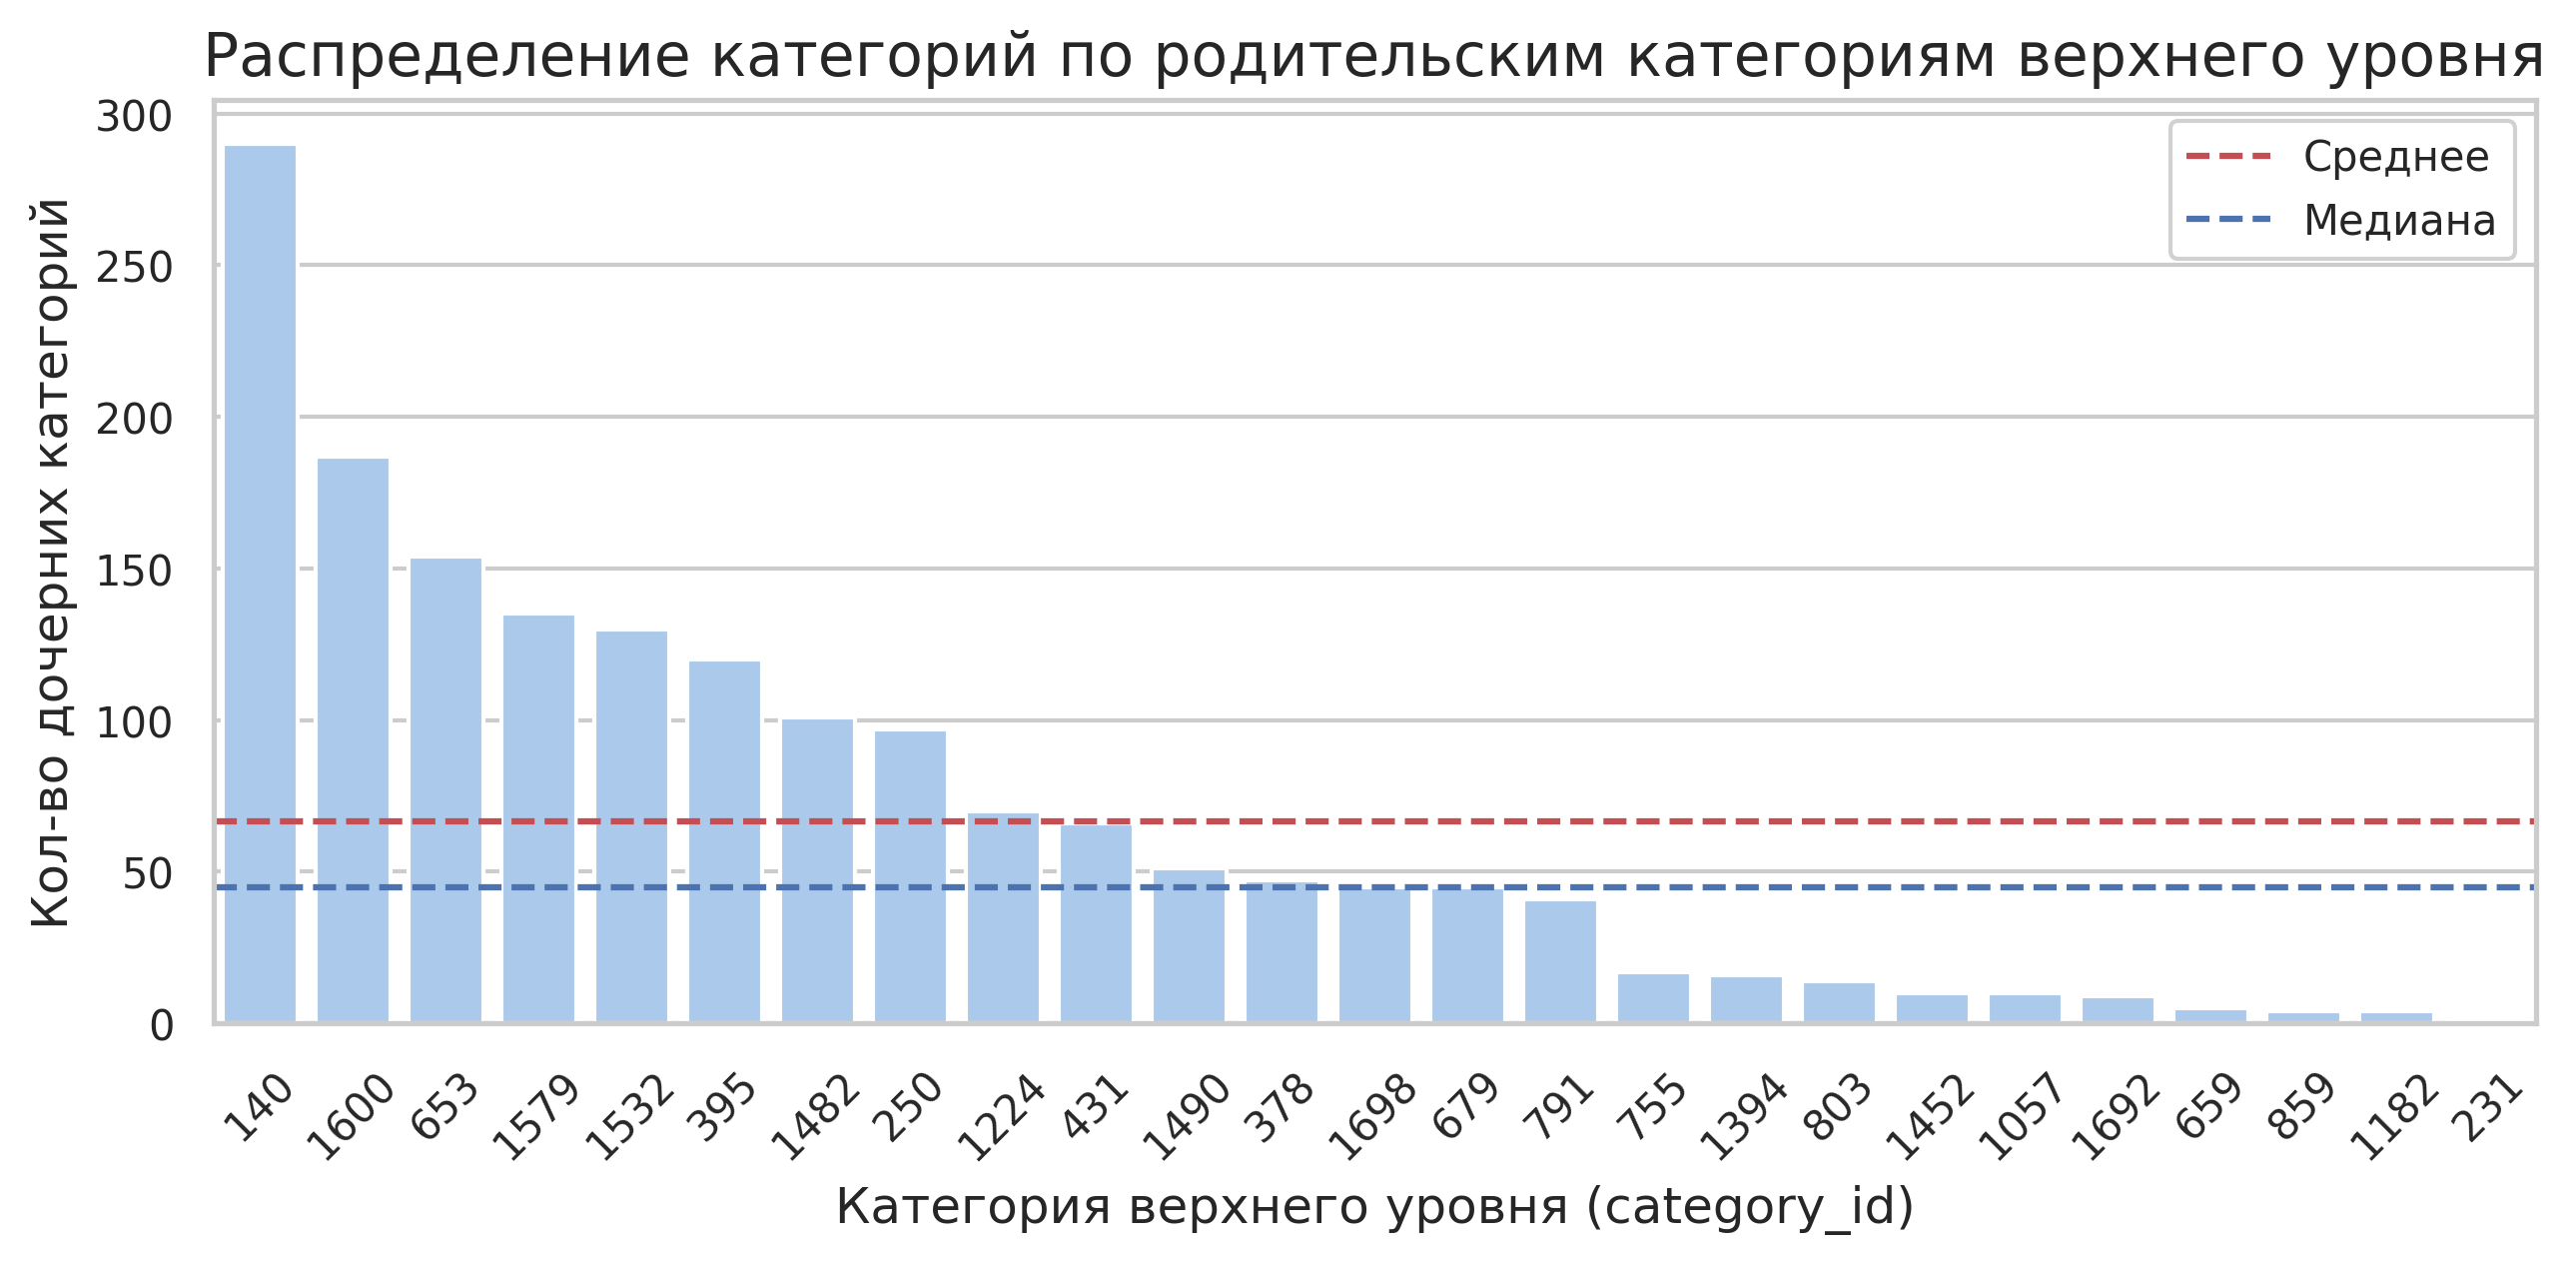

In [14]:
# Визуализируем распределние категорий по категориям верхнего уровня
ax = sns.barplot(
    category_tree['top_cat_id'].value_counts().reset_index()
    .astype(dtype={'top_cat_id': 'str'}),
    x='top_cat_id',
    y='count',
    color=sns.color_palette('pastel')[0]
)
ax.axhline(y=category_tree['top_cat_id'].value_counts().mean(),
           color='r', linestyle='--', label='Среднее')
ax.axhline(y=category_tree['top_cat_id'].value_counts().median(),
           color='b', linestyle='--', label='Медиана')
ax.xaxis.set_tick_params(rotation=45)
ax.set_xlabel('Категория верхнего уровня (category_id)')
ax.set_ylabel('Кол-во дочерних категорий')
ax.set_title('Распределение категорий по родительским категориям верхнего уровня');
plt.legend();

__Выводы по дереву категорий__:
 - Дерево категорий товаров состоит из 1669 элементов относящихся к 25 категориям верхнего (первого) уровня. В среднем, каждая из категорий верхнего уровня содержит около ~50 подкатегорий.
 - Названия (описания) категорий в исходных данных отсутствуют, сделать какие либо выводы о природе продаваемых товаров (бытовая техника, книги, фильмы) не представляется возможным.

### 3. Товары (item_properties_*.csv)

In [15]:
# Визуальный осмотр
items.head(3)

,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
2,1439089200000,395014,400,n552.000 639502 n720.000 424566


In [16]:
# Переименуем колонку itemid из эстеттических соображений
items.rename(columns={'itemid': 'item_id'}, inplace=True)

In [17]:
# Количество уникальных товаров в каталоге
print(f"Unique items: {items['item_id'].nunique()}")

Unique items: 417053


Посмотрим, какие уникальные названия свойств (property) есть в таблице:

In [18]:
properties_unique = pd.Series(items['property'].unique())
properties_numeric = pd.to_numeric(properties_unique, errors='coerce')
properties_non_numeric = properties_unique[properties_numeric.isna()].tolist()

print(f'Properties total         : {len(properties_unique)}')
print(f'  of which numeric       : {properties_numeric.notna().sum()}')
print(f'Non-numeric properties   : {properties_non_numeric}')

Properties total         : 1104
  of which numeric       : 1102
Non-numeric properties   : ['categoryid', 'available']


Имеем 1104 уникальных названий свойств в столбце 'property'. За исключением двух строковых названий ('categoryid', 'available'), все остальные значения 'property' являются числовыми.  

__NB!__ Поскольку данных для расшифровки (декодированя) числовых значений 'property' у нас нет и, к тому же, значения 'values' для них также представлены в закодрованном виде - игнорируем (удалим) числовые 'properties' из каталога items.   

In [19]:
# Из всех значений 'properties' оставляем только 'categoryid' и 'available'
items = (
    items[
        items['property'].isin(['categoryid', 'available'])
    ]
    # Отсортируем таблицу
    .sort_values(by=['item_id', 'timestamp'], ignore_index=True)
)

Приведем типы столбцов:
- 'timestamp' к _datetime_
- 'value' к _int_

In [20]:
# Приведем столбец timestamp к типу datetime
items['timestamp'] = pd.to_datetime(items['timestamp'], unit='ms')
items['value'] = items['value'].astype('int')

# Визуальная проверка
items.head(5)

,timestamp,item_id,property,value
0,2015-05-10 03:00:00,0,categoryid,209
1,2015-05-17 03:00:00,0,available,0
2,2015-05-10 03:00:00,1,available,1
3,2015-05-10 03:00:00,1,categoryid,1114
4,2015-05-17 03:00:00,1,available,0


In [21]:
# Диапазон временных меток
items['timestamp'].describe().loc[['min', 'max']]

min    2015-05-10 03:00:00
max    2015-09-13 03:00:00
Name: timestamp, dtype: object

Временные метки (timestamp) записей в таблице находятся в диапазоне от 2015-05-10 до 2015-09-13

In [22]:
# Уникальные значения для свойства 'avalable'
items[items['property'] == 'available']['value'].unique()

array([0, 1])

In [23]:
# Убедимся в том, что все товары имеют установленный признк 'available'
(
    items.query("property == 'available'")['item_id'].nunique()
    == items['item_id'].nunique()
)

True

__NB__: Все товары в каталоги имеют свойство (property) 'available', которое принимает значения 0 или 1 - судя по названию, речь идёт о доступности товара. При этом, как видно из таблицы, в разные моменты времени свойство может иметь различные значения - это, с большой долей вероятности, отражает историю доступности товара к покупке в различные моменты времени. 

In [24]:
# Для удобства создадим отдельную таблицу items_cats, содержащую только
# свойство categoryid
items_cats = (
    items
    .query("property == 'categoryid'")
    .drop(columns='property')
    .rename(columns={'value': 'category_id'})
    .sort_values(by=['item_id', 'timestamp'], ignore_index=True)
)

# Визуальная проверка
items_cats.head(3)

,timestamp,item_id,category_id
0,2015-05-10 03:00:00,0,209
1,2015-05-10 03:00:00,1,1114
2,2015-05-10 03:00:00,2,1305


In [25]:
# Убедимся в том, что все товары имеют признк категории
items_cats['item_id'].nunique() == items['item_id'].nunique()

True

In [26]:
# Проверим на наличие у товаров различных/дублирующихся признаков категорий
items_cats[items_cats['item_id'].duplicated(keep=False)].iloc[-6:-2]

,timestamp,item_id,category_id
788174,2015-08-09 03:00:00,466829,1277
788175,2015-08-16 03:00:00,466829,1277
788176,2015-08-23 03:00:00,466829,438
788177,2015-08-30 03:00:00,466829,438


__NB__ Все товары в таблице имеют признк (categoryid) отнесения к какой-либо категории. Аналогично признаку доступности, признак категории (categoryid) может изменяеться с течением времени __[!] Интерпретируем следующим образом: примем, что товар относится к одной категории, с самой последней временной меткой (относительно времени расчета)__. 

Проверим, что все значения категории товаров могут быть найдены в дереве категорий

In [27]:
# Категории, присутствующие в каталоге, но отсутствующие в дереве категорий
weird_cats = (
    set(items_cats['category_id'].drop_duplicates()) 
    - set(category_tree['category_id'])
)

# Количество дополнитлеьных категорий (которых нет в дереве)
print(f'Weird categories: {len(weird_cats)}')

# Кол-во товаров, относимых к дополнительным категориям
print(
    'Items associated with weird categories:', 
    items_cats[items_cats['category_id'].isin(weird_cats)]['item_id'].nunique()
)

Weird categories: 30
Items associated with weird categories: 137


В кателоге товаров присутствуют 30 'дополнительных' категорий, которые отсутствуют в дереве категорий (табица category_tree). С этими 'дополнительными' категориями связано 137 товаров. Будем надеяться, что с данными товарами пользователи не взаимодействуют 😉 

Визуализируем распределение товаров по топ-категориям верхнего уровня.   
В качестве временной точки возьмем самую позднюю известную дату (2015-09-13).

In [28]:
# Подготовим отдельную таблицу items_graph для построения графика

# Отфильтруем данные по категориям, остатвив только последние значения 
# по времени 
items_graph = (
    items_cats
    .sort_values(by=['item_id', 'timestamp'], ignore_index=True)
    .groupby('item_id')
    .tail(1)
)

# Добавим признак доступности товара - 'available' (последние значения)
items_graph = items_graph.merge(
    items
    .query("property == 'available'")
    .sort_values(by=['item_id', 'timestamp'], ignore_index=True)
    .groupby('item_id')
    .tail(1)
    [['item_id', 'value']]
    .rename(columns={'value': 'available'}),
    on='item_id',
    how='left'
)

# Добавим категорию верхнего уровня
items_graph = items_graph.merge(
    category_tree[['category_id', 'top_cat_id']],
    on='category_id',
    how='left'
)

# Уберем пропуски в top_cat_id (из за дополнительнвх категорий) и приведем типы
items_graph = (
    items_graph
    .dropna()
    .astype(dtype={'top_cat_id': 'int', 'available': 'bool'})
)

# Общаая доля доступных товаров
items_graph['available'].value_counts()

available
False    362911
True      54010
Name: count, dtype: int64

Из более 400 тыс. товаров на конец известного периода (2015-09-13) доступно к покупке около 54 тыс. (13%)

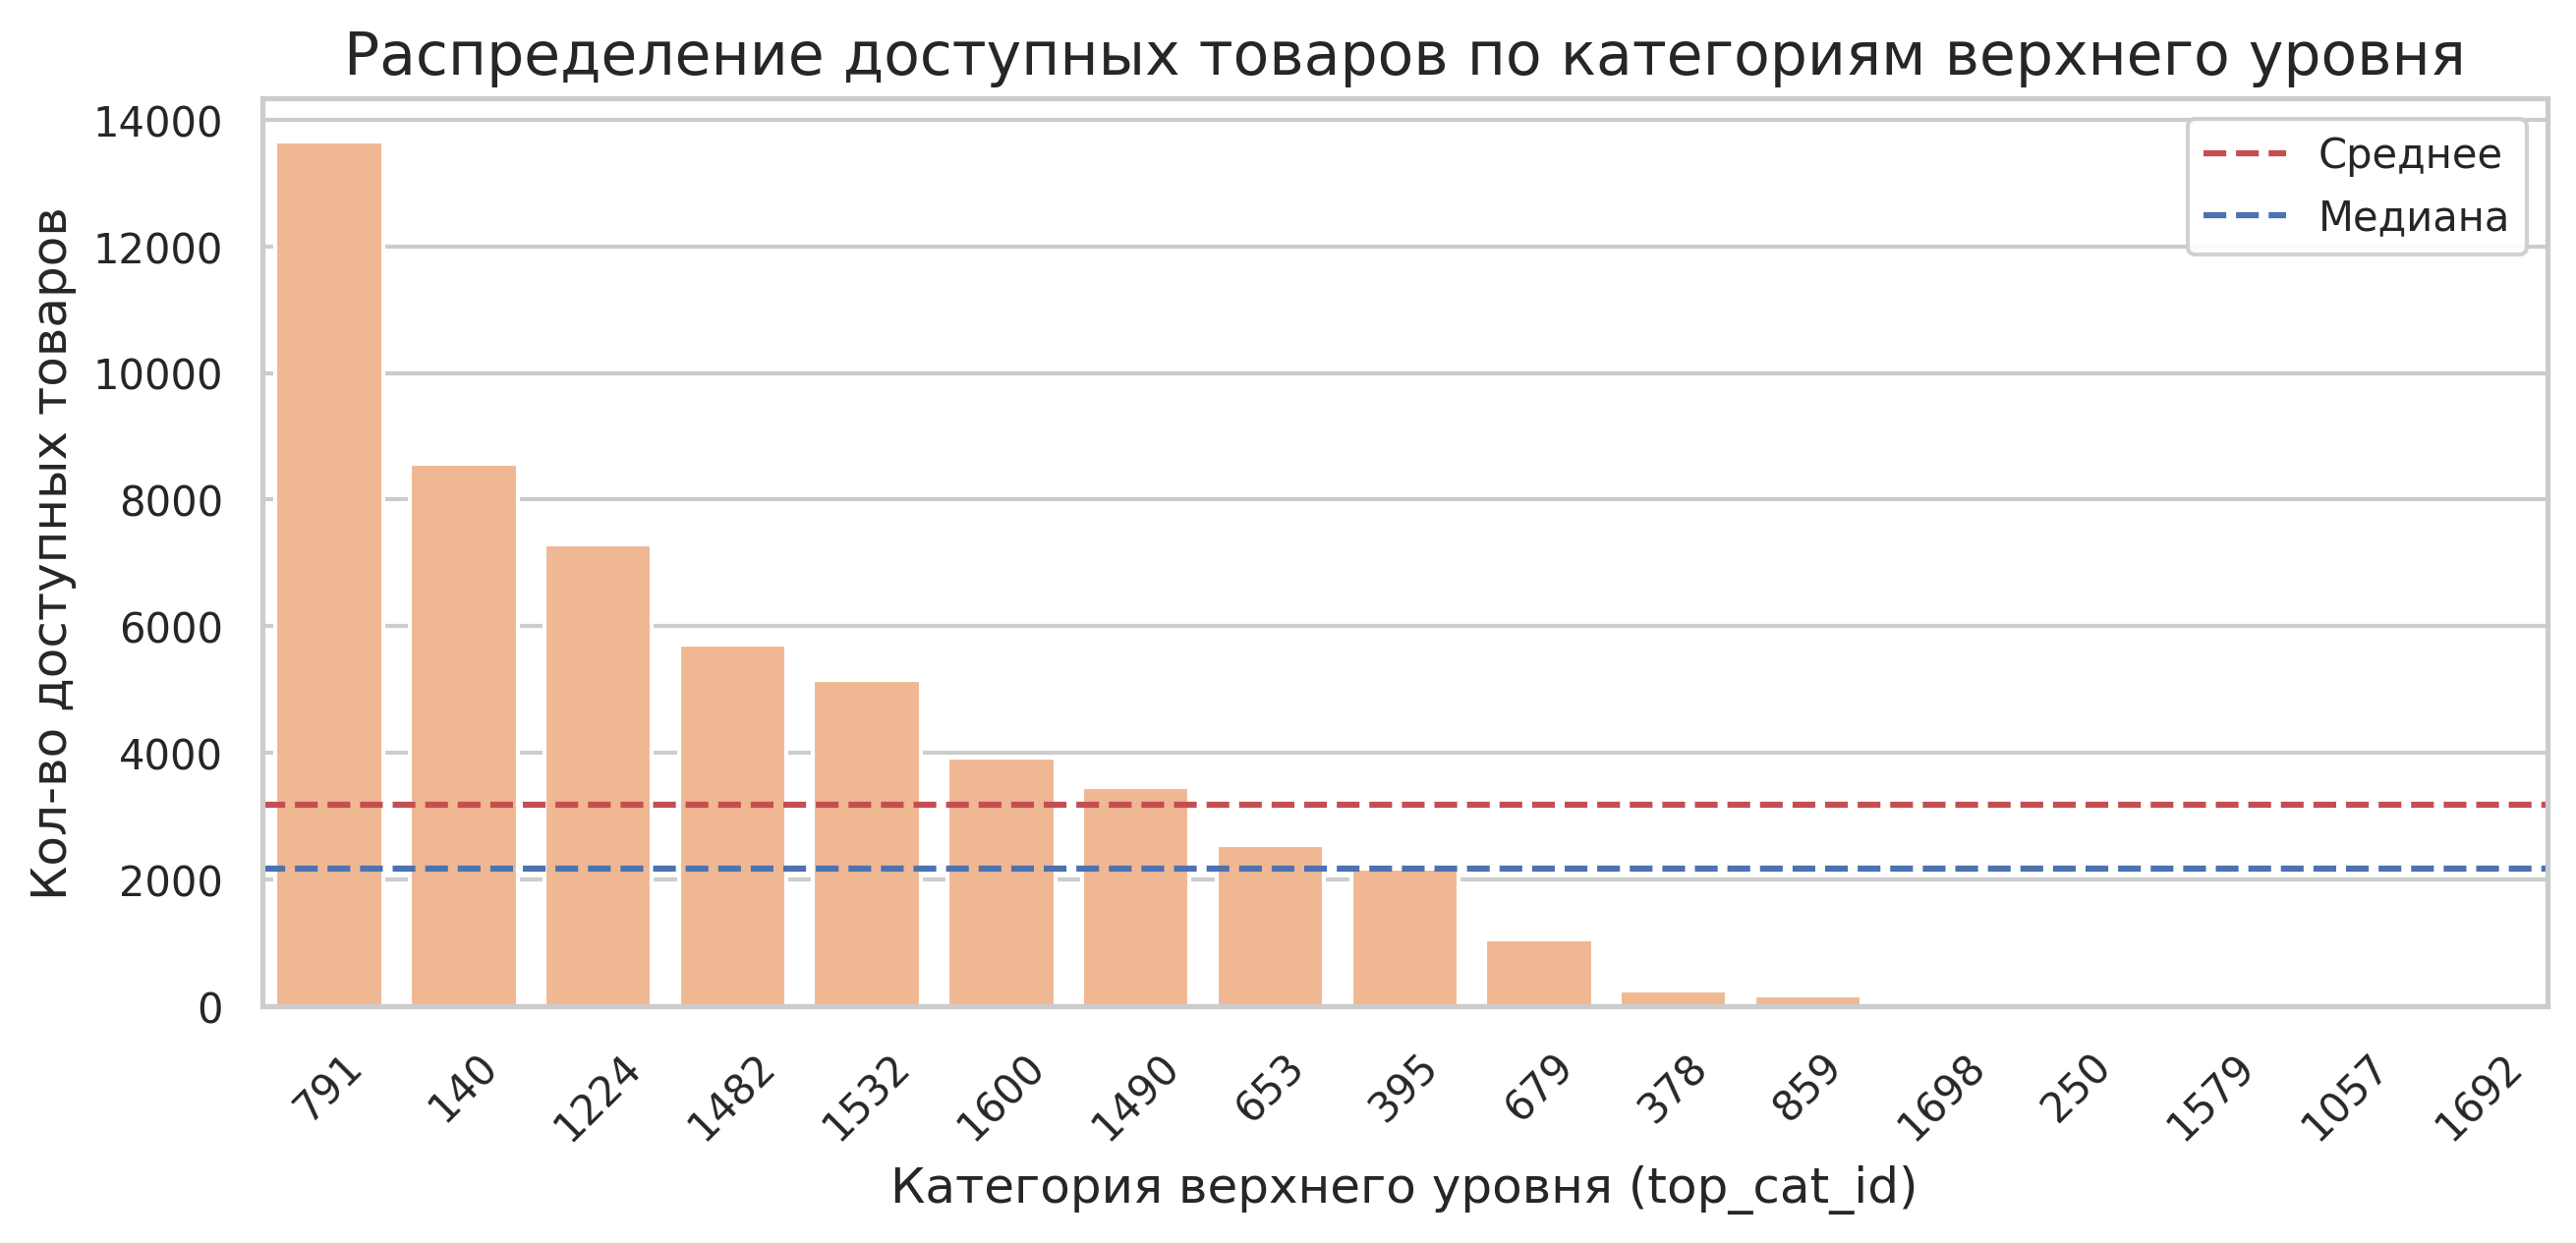

In [29]:
ax = sns.barplot(
    items_graph.query('available == True')
    ['top_cat_id']
    .value_counts()
    .reset_index()
    .astype(dtype={'top_cat_id': 'str'}),
    x='top_cat_id',
    y='count',
    color=sns.color_palette('pastel')[1]
)
ax.axhline(y=items_graph.query('available == True')['top_cat_id']
           .value_counts().mean(), color='r', linestyle='--', label='Среднее')
ax.axhline(y=items_graph.query('available == True')['top_cat_id']
           .value_counts().median(), color='b', linestyle='--', label='Медиана')
ax.xaxis.set_tick_params(rotation=45)
ax.set_xlabel('Категория верхнего уровня (top_cat_id)')
ax.set_ylabel('Кол-во доступных товаров')
ax.set_title('Распределение доступных товаров по категориям верхнего уровня');
plt.legend();

__Выводы по каталогу товаров__:
- Каталог содержит 417 тыс. уникальных товаров  

- Имеем 1104 уникальных названий свойств в столбце 'property'. За исключением двух строковых названий ('categoryid', 'available'), все остальные значения 'property' являются числовыми. Данных для расшифровки (декодированя) числовых значений 'property' у нас нет и, к тому же, значения 'values' для них также представлены в закодрованном виде - игнорируем (удалим) числовые 'properties' из каталога items.   

- Временные метки (timestamp) записей в таблице находятся в диапазоне от 2015-05-10 до 2015-09-13  

- Все товары в каталоги имеют свойство (property) 'available', которое принимает значения 0 или 1 - судя по названию, речь идёт о доступности товара. При этом, как видно из таблицы, в разные моменты времени свойство может иметь различные значения - это, с большой долей вероятности, отражает историю доступности товара к покупке в различные моменты времени.  

- Все товары в таблице имеют признк (categoryid) отнесения к какой-либо категории. Аналогично признаку доступности, признак категории (categoryid) может изменяеться с течением времени __[!] Интерпретируем следующим образом: примем, что товар относится к одной категории, с самой последней временной меткой (относительно времени расчета)__.   

- В кателоге товаров присутствуют 30 'дополнительных' категорий, которые отсутствуют в дереве категорий (табица category_tree). С этими 'дополнительными' категориями связано 137 товаров. Будем надеяться, что с данными товарами пользователи не взаимодействуют 😉 

- Из более 400 тыс. товаров на конец известного периода (2015-09-13) доступно к покупке около 54 тыс. (13%)

### 4. События (events.csv)

In [30]:
# Визуальный осмотр
events.head(3)

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN


In [31]:
# Переименуем столбцы для удобства 
events.rename(
    columns={
        'visitorid': 'user_id',
        'itemid': 'item_id',
        'transactionid': 'transaction_id'
    }, 
    inplace=True
)

# Приведем timestamp к типу datetime
events['timestamp'] = pd.to_datetime(events['timestamp'], unit='ms')

# Визуальная проверка
events.head(3)

,timestamp,user_id,event,item_id,transaction_id
0,2015-06-02 05:02:12.117,257597,view,355908,NaN
1,2015-06-02 05:50:14.164,992329,view,248676,NaN
2,2015-06-02 05:13:19.827,111016,view,318965,NaN


In [32]:
events.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2756101 entries, 0 to 2756100
Data columns (total 5 columns):
 #   Column          Dtype         
---  ------          -----         
 0   timestamp       datetime64[ns]
 1   user_id         int64         
 2   event           object        
 3   item_id         int64         
 4   transaction_id  float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 244.9 MB


In [33]:
events['timestamp'].describe().loc[['min', 'max']]

min    2015-05-03 03:00:04.384000
max    2015-09-18 02:59:47.788000
Name: timestamp, dtype: object

Таблица событий содержит данные о 2.7 млн. взаимодействий пользователей и товаров в период с 2015-05-03 по 2015-09-18

In [34]:
# Распределение событий по типам транзакций
events['event'].value_counts() # (normalize=True)

event
view           2664312
addtocart        69332
transaction      22457
Name: count, dtype: int64

97% от общего числа событий это просмотр товара, 70 тыс.(3%) - добавление в корзину, 22 тыс.(1%) - покупка.

In [35]:
# Число уникальных пользователей
print(f'Unique users: {events["user_id"].nunique()}')

# Униикальны пользователи по типам взаимодействий
events.groupby('event')['user_id'].nunique()

Unique users: 1407580


event
addtocart        37722
transaction      11719
view           1404179
Name: user_id, dtype: int64

Всего с сервисом взаимодействовало 1.4 млн. униакальных пользователей, при этом добавляли товар в корзину только 37 тыс. (3%), а совершили покупку 12 тыс. (1%)

In [36]:
# Число уникальных товаров
events['item_id'].nunique()

# Уникальные товары по типам взаимодейсвий
events.groupby('event')['item_id'].nunique()

event
addtocart       23903
transaction     12025
view           234838
Name: item_id, dtype: int64

Всего пользователи просмотрели 239 тыс. униакальных товаров, при этом добавили в коризину 23 тыс. уникальных товаров (~10% от просматриваемых), а купили 12 тыс. (~5% от просматриваемых).

In [37]:
# Отсортируем таблицу по времени 
events.sort_values(by='timestamp', inplace=True, ignore_index=True)

# Добавим в таблицу столбец с датой
events['date'] = events['timestamp'].dt.date

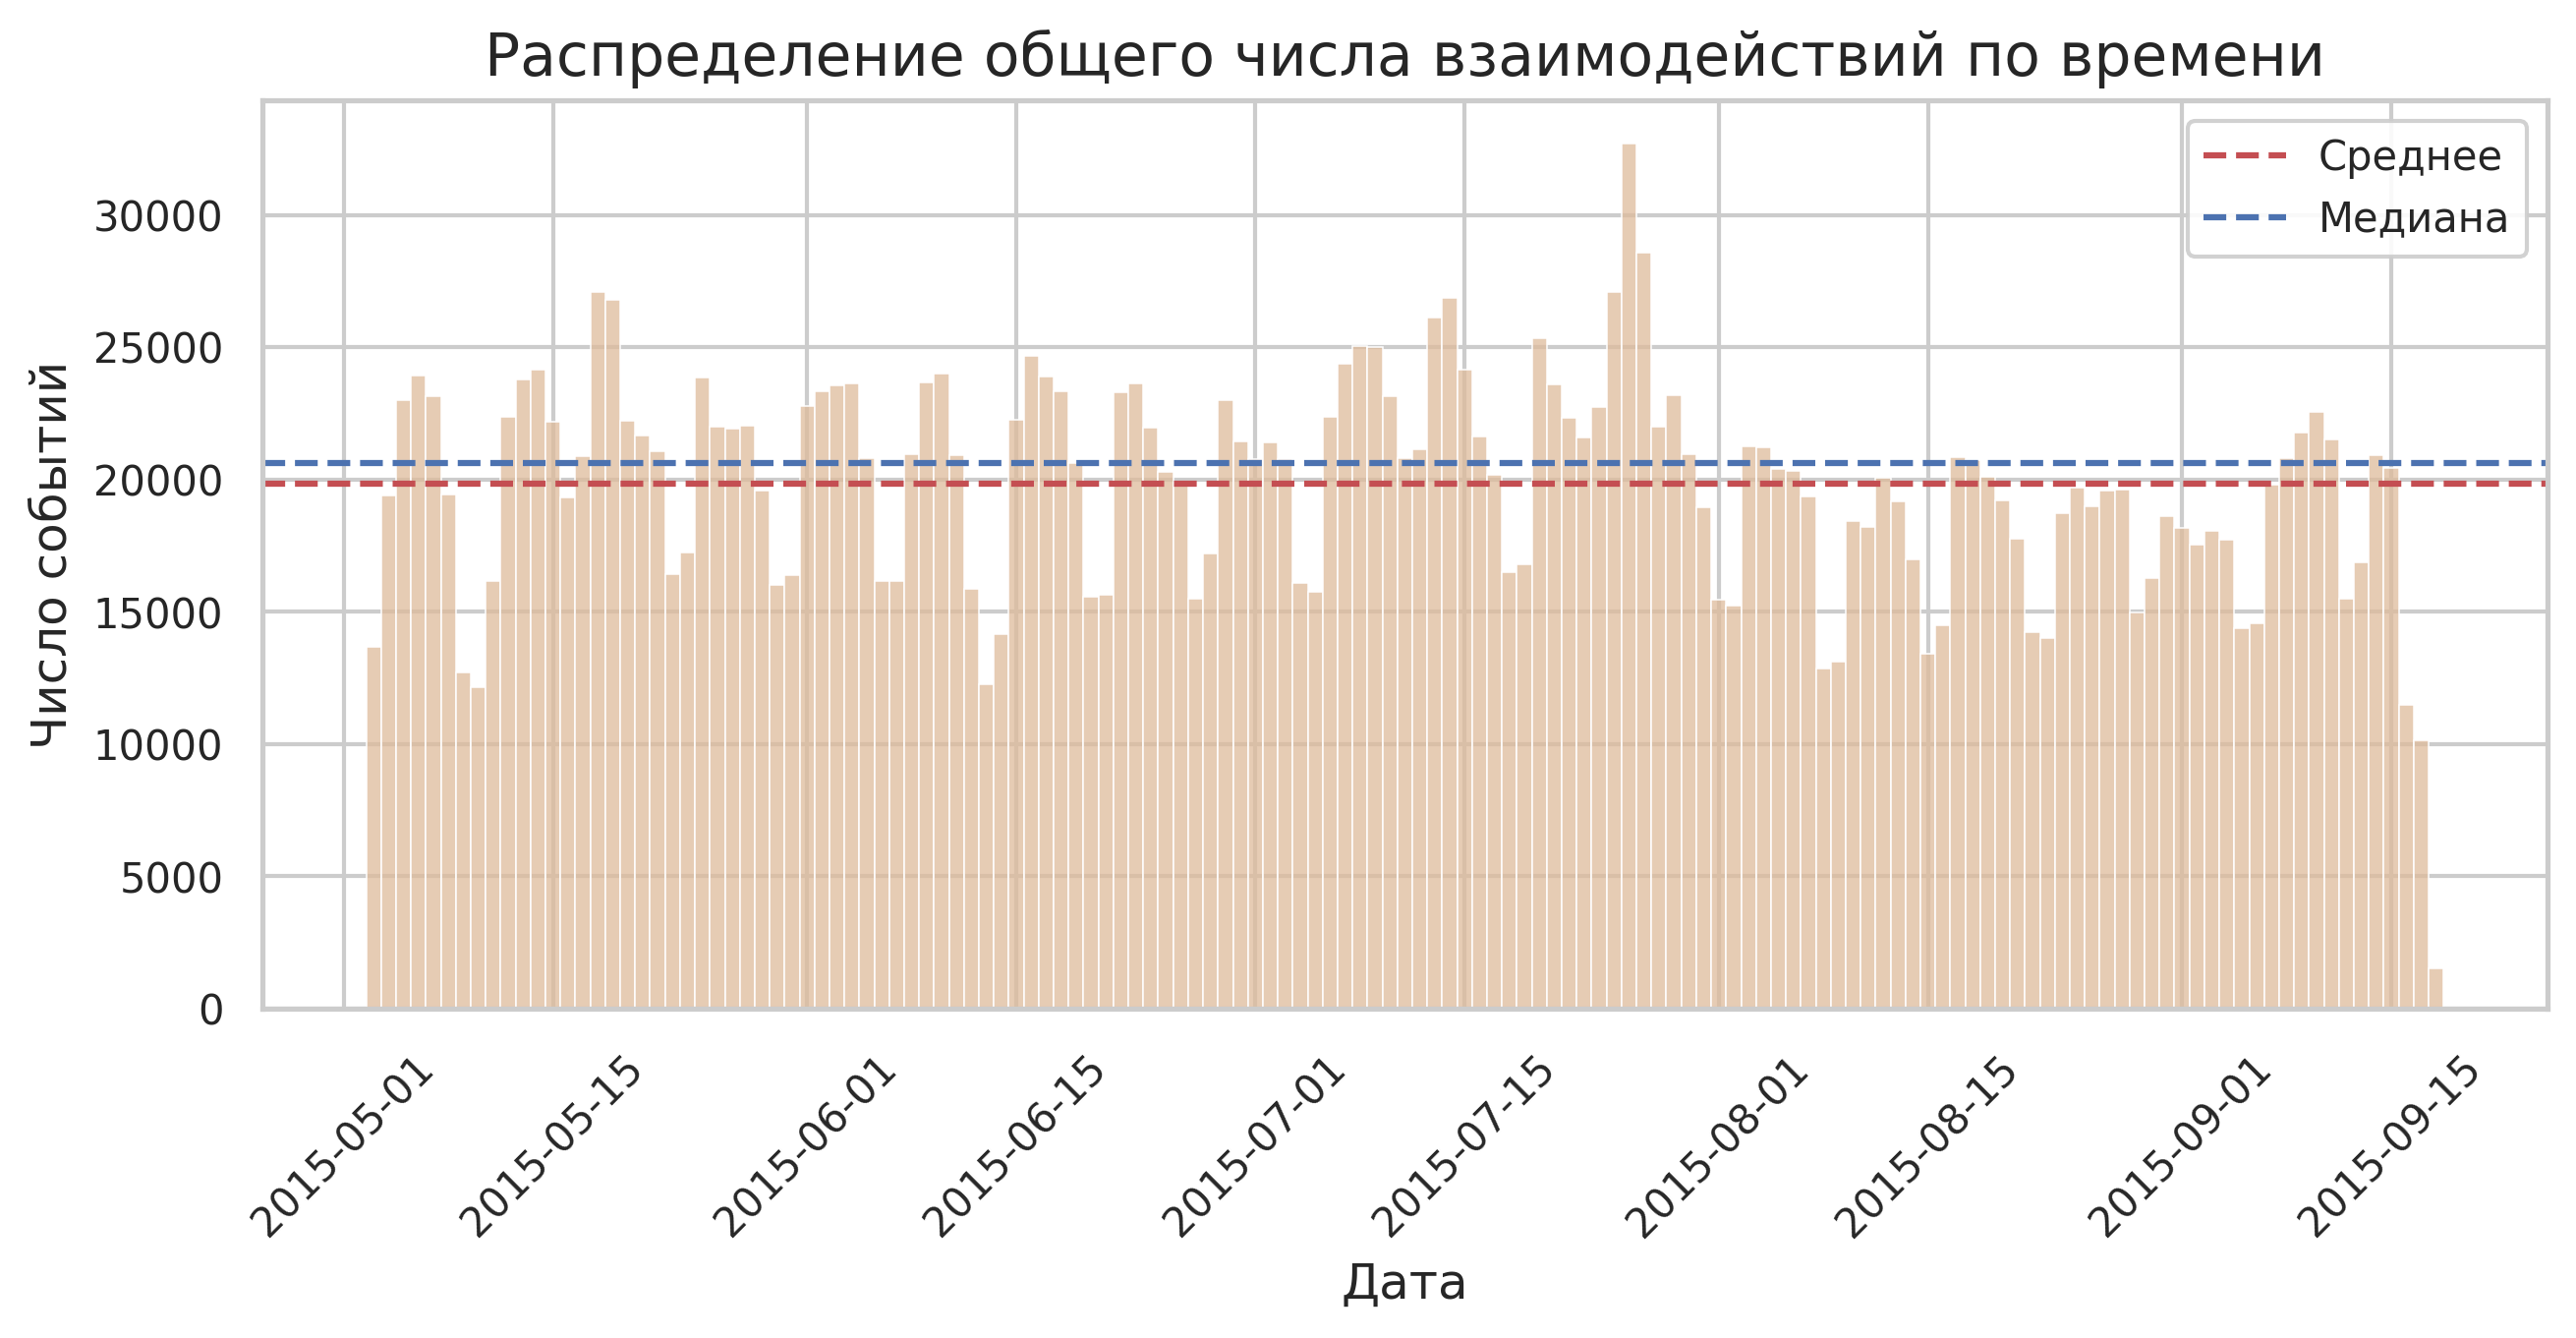

In [38]:
# Изменение числа взаимодействий по времени
ax = sns.histplot(
    events[['date']], 
    x='date',
    color=sns.color_palette('pastel')[5]
)

ax.axhline(y=events.groupby('date')['timestamp'].count().mean(),
           color='r', linestyle='--', label='Среднее')
ax.axhline(y=events.groupby('date')['timestamp'].count().median(),
           color='b', linestyle='--', label='Медиана')
ax.xaxis.set_tick_params(rotation=45)
ax.set_xlabel('Дата')
ax.set_ylabel('Число событий')
ax.set_title('Распределение общего числа взаимодействий по времени')
plt.legend();

Поток событий (взаимодействий) пользователей с товарами распределен с мая по сентябрь достаточно равномерно, в среднем пользователи взаимодействуют (в основном посматривают) товары около 20 тыс. раз в день. 

In [39]:
# Cтатистики числа значимых событий в день
print('Число юобавлений в корзину в день:')
display(events.query("event == 'addtocart'").groupby('date')
        ['timestamp'].count().describe().loc[['mean', '50%']])

print('Число покупок в день:')
display(events.query("event == 'transaction'").groupby('date')
        ['timestamp'].count().describe().loc[['mean', '50%']])

Число юобавлений в корзину в день:


mean   498.79
50%    514.00
Name: timestamp, dtype: float64

Число покупок в день:


mean   161.56
50%    162.00
Name: timestamp, dtype: float64

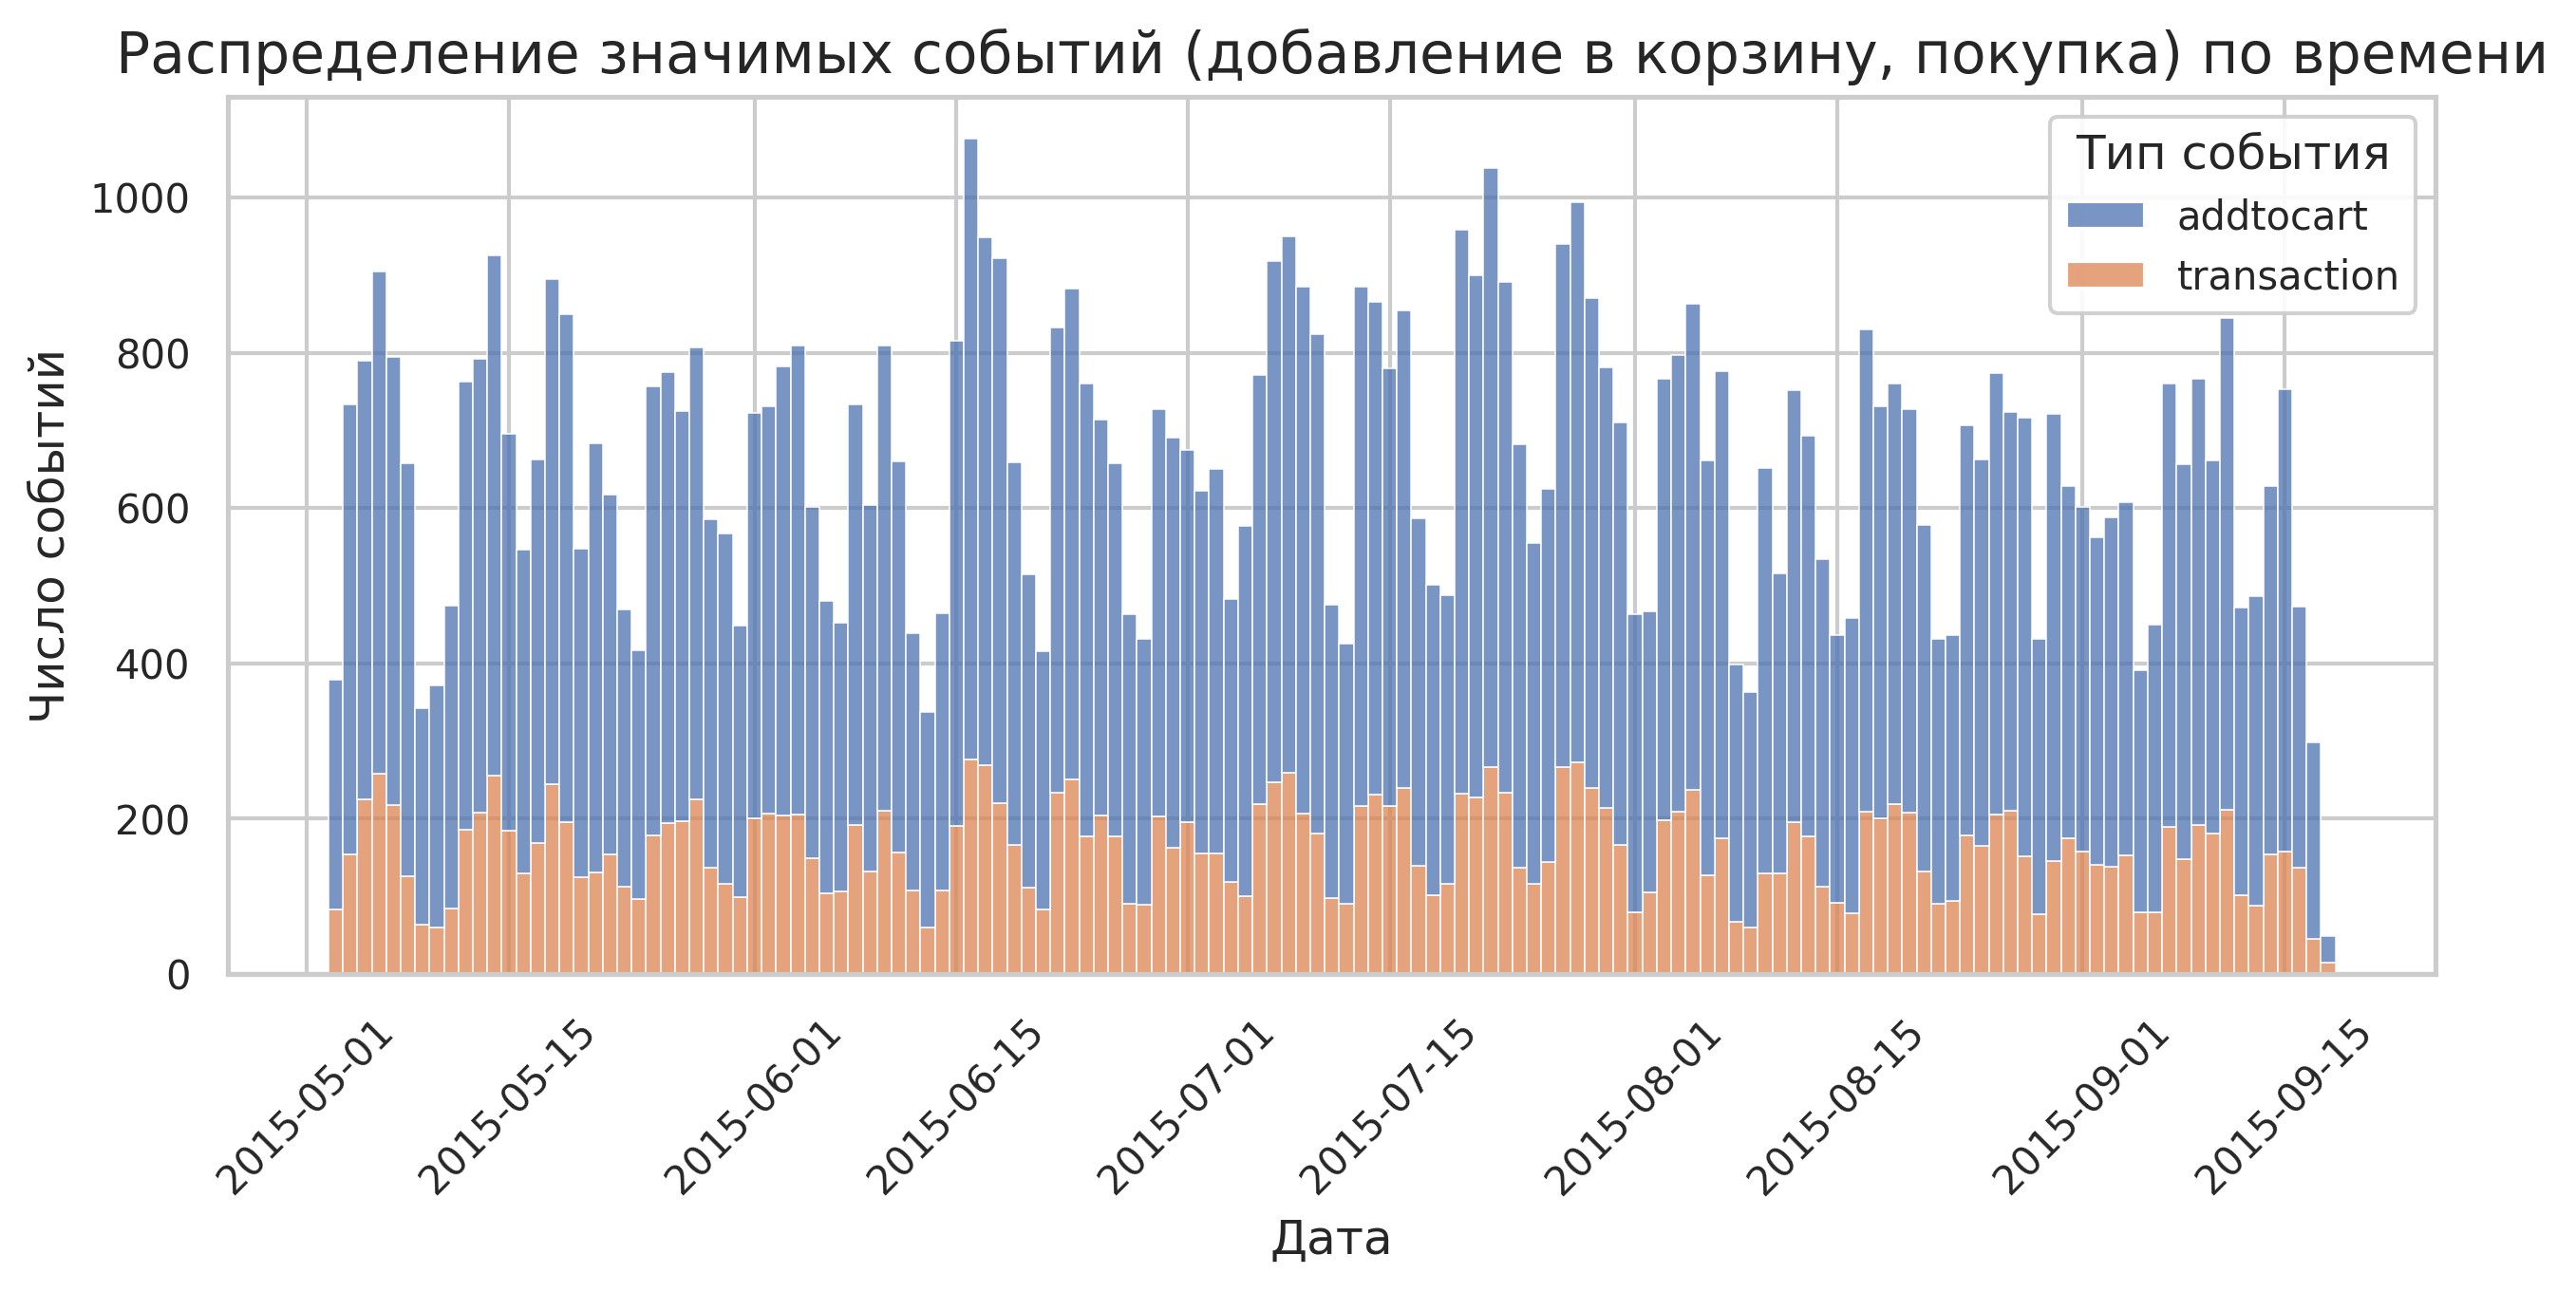

In [40]:
# Изменение числа значимых событий по времени
ax = sns.histplot(
    events.query("event != 'view'")[['date', 'event']], 
    x='date',
    # color=sns.color_palette('pastel')[0],
    hue='event',
    multiple='stack'
)
ax.get_legend().set_title('Тип события')
ax.xaxis.set_tick_params(rotation=45)
ax.set_xlabel('Дата')
ax.set_ylabel('Число событий')
ax.set_title('Распределение значимых событий (добавление в корзину, покупка) по времени');

Значимые события (добавление в корзину, покупка) распределены по времени также достаточно равномерно (с учетом недельной сезонности), в среднем пользователи добавляют товар в корзину около 500 раз в день, совершают покупку около 160 раз в день.

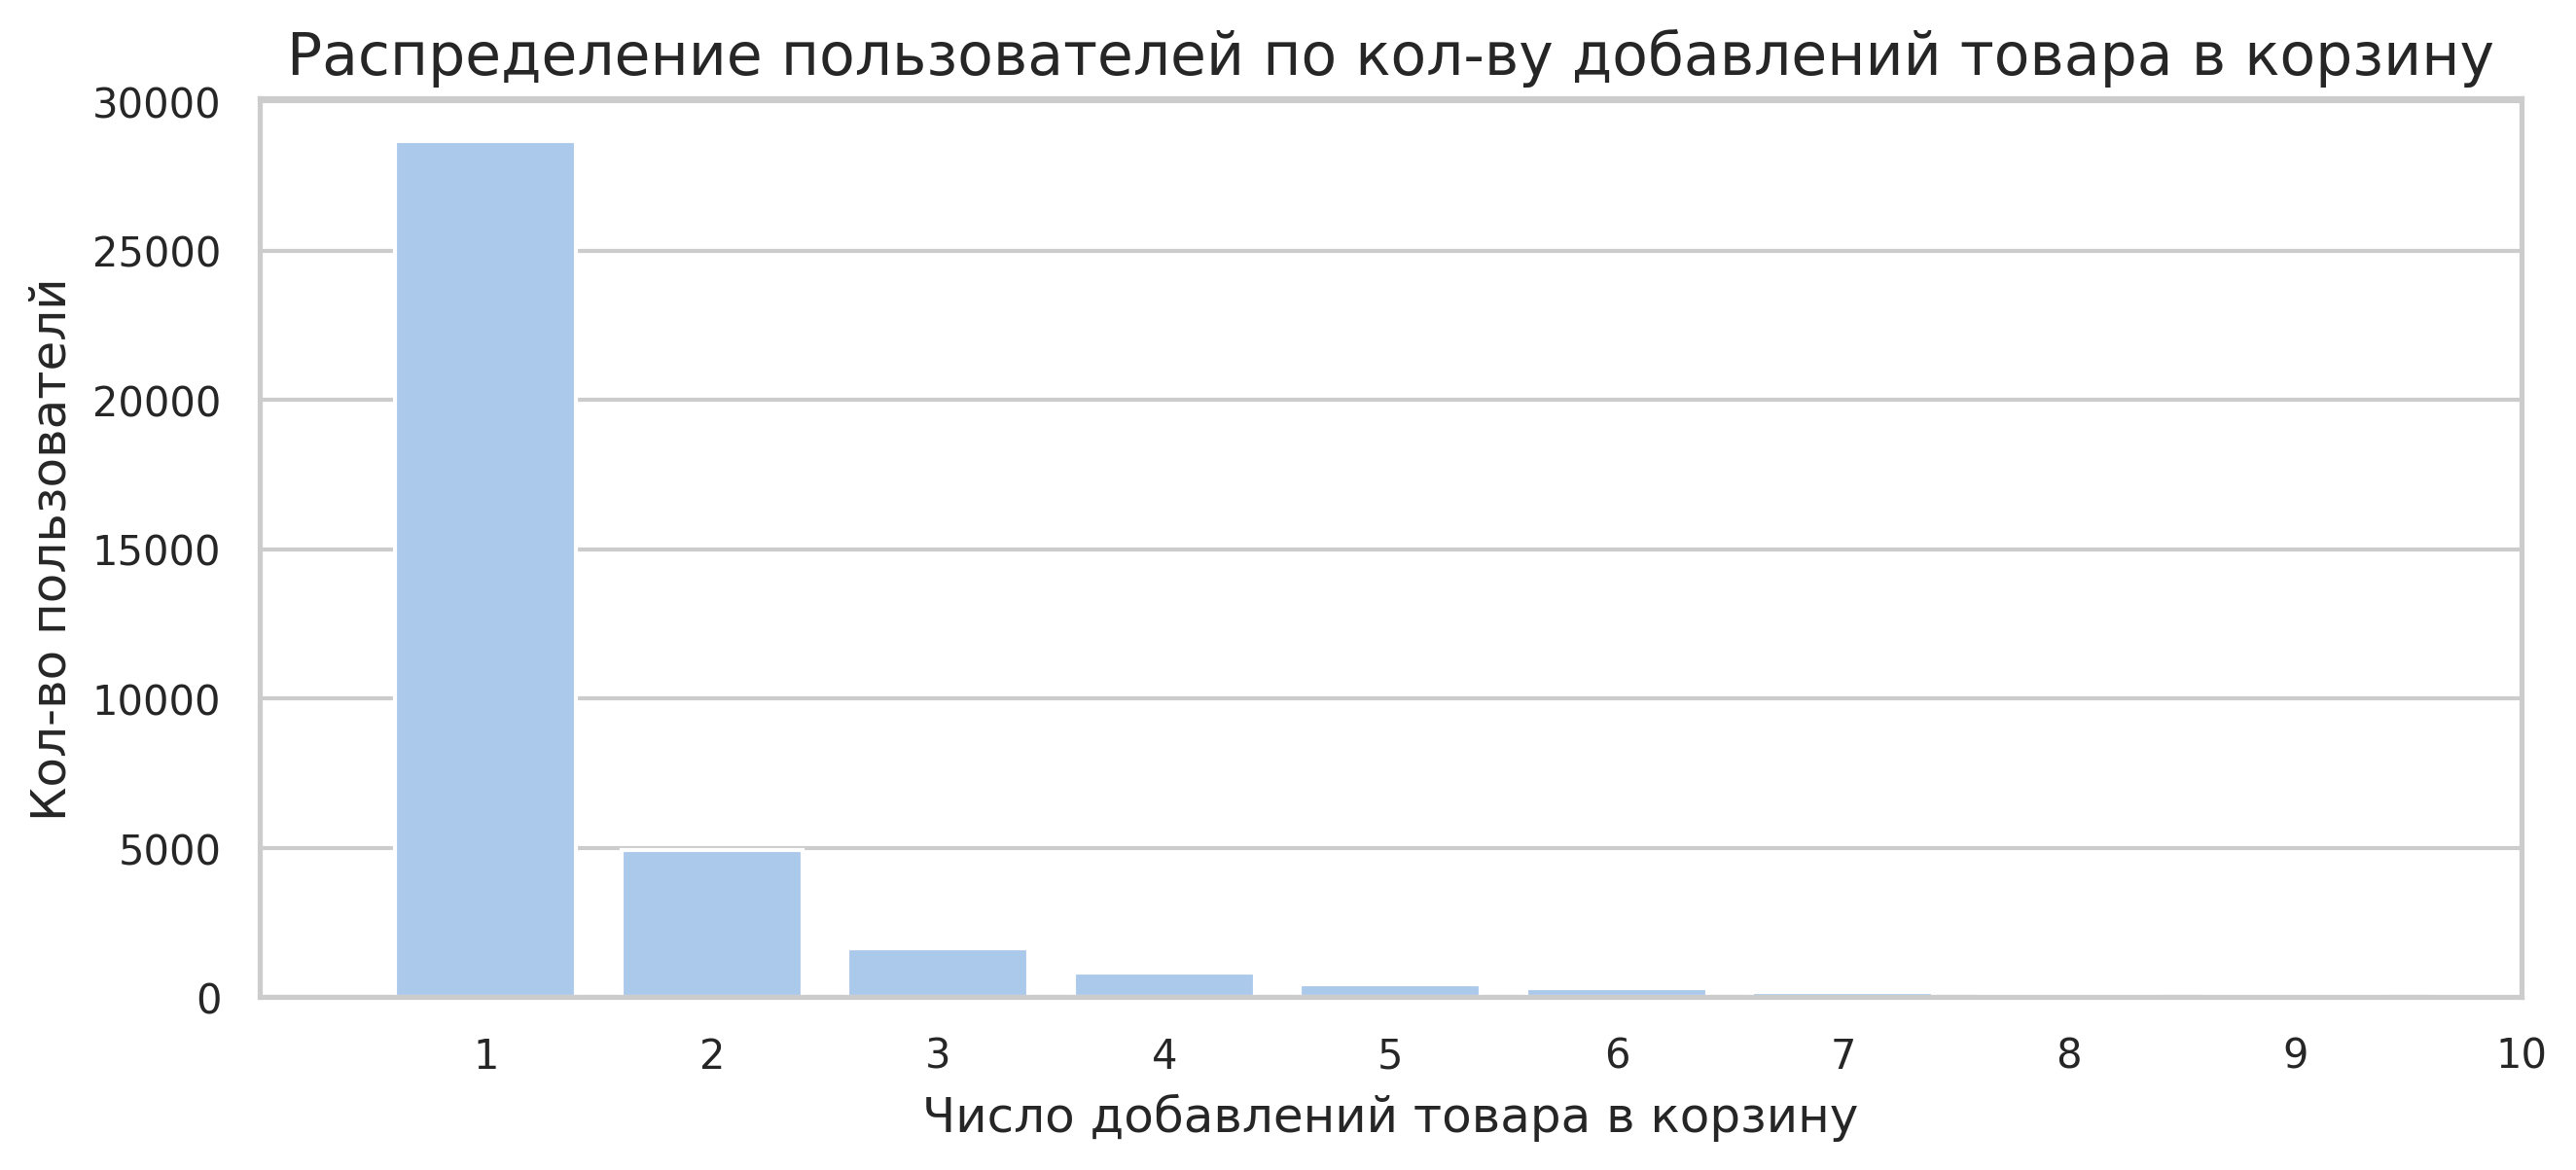

In [41]:
# Сгруппируем пользователей по кол-ву событий добавления товара в корзину
events_users = (
    events
    .query("event == 'addtocart'")
    .groupby('user_id')
    .agg(event_count=('event', 'count'))
    .reset_index()
    .groupby('event_count')
    .agg(user_count=('user_id', 'count'))
    .reset_index()
)
ax = sns.barplot(
    events_users,
    x='event_count',
    y='user_count',
    color=sns.color_palette('pastel')[0]
)
ax.set_xlim((-1,9));
ax.set_xlabel('Число добавлений товара в корзину')
ax.set_ylabel('Кол-во пользователй')
ax.set_title('Распределение пользователей по кол-ву добавлений товара в корзину');

Еще раз обратим внимание, на низкую частотность значимых событий - более 75% процентов пользователей, которые добавляли товар в корзину, сделали это только 1 (один) раз. 

Проверим, все ли взаимодействия происходят с товарами, которые есть в каталоге items

In [42]:
events['item_id'].drop_duplicates().isin(items['item_id'].unique()).all()

np.False_

In [43]:
# Количество 'неизвестных' товаров, т.е. тех, которых нет в каталоге,
# но с которыми были взаимодействия
itemids_in_items = set(items['item_id'].drop_duplicates())
itemids_in_events = set(events['item_id'].drop_duplicates())

weird_itemids = itemids_in_events - itemids_in_items

print(f'Weird (unknown) items in events: {len(weird_itemids)} '
      f'({len(weird_itemids)/len(itemids_in_events):.1%})')

# Количество взаимодействий с 'неизвестными' товарами
weird_events = events[events["item_id"].isin(weird_itemids)]
print(f'Interactions with weird (unknown) items: '
      f'{len(weird_events)} '
      f'({len(weird_events)/len(events):.1%})')

Weird (unknown) items in events: 49815 (21.2%)
Interactions with weird (unknown) items: 255585 (9.3%)


В таблице событий присутствует около 50 тыс. 'неизвестных' товаров (отсутствующих в каталоге товаров items), что составляет около 20% от общего числа товаров, с которыми взаимодействовали пользователи.  
 При этом, суммарное число взаимодействий с 'неизвестными' товарами составляет только ~9% (255 тыс.) от общего числа событий. Таким образом, интерес (среднее кол-во взаимодействий) пользователей к 'неизвестным' товарам в среднем ниже, чем интерес к товарам, о которых есть информация в таблице items.

In [44]:
# Удалим события, которые относятся к 'неизвестным' товарам
events = events[
    events['item_id'].isin(items['item_id'].drop_duplicates())
].reset_index(drop=True)

Проверим доступность (availability) товара в момент добавления в корзину - для каждого из событий добавления товара в корзину найдем последнее по времени значение признака 'available' из таблицы items, которое было установлено ДО момента самого события (добавления в корзину).  

In [45]:
# Отфильтруем каталог, оставив только признак доступности (availabilty)
items_availability = (
    items.query('property == "available"')
    .reset_index(drop=True)
)

In [46]:
# В качестве теста возбмем события только за последний месяц (сентябрь)
availability_values = pd.Series([
    # берем последнее (по времени) значение availability
    values[-1]
    if len(values:=(
        # из каталога отфильтрованного по конкретному товару и 
        # времени ДО момента добавления данного товара в корзину
        items_availability[
            (items_availability['item_id'] == item_id)
            & (items_availability['timestamp'] < timestamp)
        ]
        .sort_values('timestamp')
        ['value']
        .tolist()
    ))
    else pd.NA  
    # перебираем временные метки и товары для событий добавления в корзину
    for timestamp, item_id  
    in (
        events[
            (events['event'] == 'addtocart')
            & (events['timestamp'].dt.month == 9)
        ]
        [['timestamp', 'item_id']]
        .itertuples(index=False)
    )
])
availability_values.value_counts(dropna=False)

1       6980
0        446
<NA>     128
Name: count, dtype: int64

Видим значитлеьное (~10%) число событий, для которых __в момент добавления в товара корзину сам товар был недоступен (availabilty = 0) или признак availability вообще отсутствовал (еще не был установлен)__  

Для чистоты эксперимента проверим также доступность (availability) товара __в момент транзакции (покупки)__ 

In [47]:
# В качестве теста возбмем события за последние два месяца (август-сентябрь)
availability_values = pd.Series([
    # берем последнее (по времени) значение availability
    values[-1]
    if len(values:=(
        # из каталога отфильтрованного по конкретному товару и 
        # времени ДО момента транзакции (покупки)
        items_availability[
            (items_availability['item_id'] == item_id)
            & (items_availability['timestamp'] < timestamp)
        ]
        .sort_values('timestamp')
        ['value']
        .tolist()
    ))
    else pd.NA  
    # перебираем временные метки и товары для событий покупки
    for timestamp, item_id  
    in (
        events[
            (events['event'] == 'transaction')
            & (events['timestamp'].dt.month >= 8)
        ]
        [['timestamp', 'item_id']]
        .itertuples(index=False)
    )
])
availability_values.value_counts(dropna=False)

1       6200
0        500
<NA>     126
Name: count, dtype: int64

Для событий покупки товара ситуаия аналогичная - видим значитлеьное (~10%) число событий, для которых __в момент покупки товар был недоступен (availabilty = 0) или признак availability вообще отсутствовал (еще не был установлен)__ 

Как следствие, бизнес-значнеие признака (свойства) availabilty требует уточнения и использование его для построения модели (системы рекомендаций) представляется нецелессобразным. 

Проверим, наличие у товара признака отнесения к категории на момент добавления в корзину.

In [48]:
# В качестве теста возбмем события только за последний месяц (сентябрь)
category_values = pd.Series([
    # берем последнее (по времени) значение category_id
    values[-1]
    if len(values:=(
        # из каталога отфильтрованного по конкретному товару и 
        # времени ДО момента добавления данного товара в корзину
        items_cats[
            (items_cats['item_id'] == item_id)
            & (items_cats['timestamp'] < timestamp)
        ]
        .sort_values('timestamp')
        ['category_id']
        .tolist()
    ))
    else pd.NA  
    # перебираем временные метки и товары для событий добавления в корзину
    for timestamp, item_id  
    in (
        events[
            (events['event'] == 'addtocart')
            & (events['timestamp'].dt.month == 9)
        ]
        [['timestamp', 'item_id']]
        .itertuples(index=False)
    )
])

# Кол-во событий, для которых в момент добавления в корзину 
# в каталоге отсутствует (еще не добавлен) признак категории товара
print('Events with item category_id not set (yet): '
      f'{category_values.isna().sum()} '
      f'({category_values.isna().sum() / len(category_values):.1%})')

Events with item category_id not set (yet): 140 (1.9%)


__Для ~2% событий добавления товара в корзину, в момент совершения события в каталоге items еще отсутствовала запись о категории товара__ - другими словами, в этих случаях информация о категории товара (category_id) появляется в каталоге itemd позже, чем происходит само событие (добавление в корзину). 


__Выводы по событиям__:

- Таблица событий содержит данные о 2.7 млн. взаимодействий пользователей и товаров в период с 2015-05-03 по 2015-09-18  

- 97% от общего числа событий это просмотр товара, 70 тыс.(3%) - добавление в корзину, 22 тыс.(1%) - покупка. 

- Всего с сервисом взаимодействовало 1.4 млн. униакальных пользователей, при этом добавляли товар в корзину только 37 тыс. (3%), а совершили покупку 12 тыс. (1%)  

- Всего пользователи просмотрели 239 тыс. униакальных товаров, при этом добавили в коризину 23 тыс. уникальных товаров (~10% от просматриваемых), а купили 12 тыс. (~5% от просматриваемых).

- Поток событий (взаимодействий) пользователей с товарами распределен с мая по сентябрь достаточно равномерно, в среднем пользователи взаимодействуют (в основном посматривают) товары около 20 тыс. раз в день.   

- Значимые события (добавление в корзину, покупка) распределены по времени также достаточно равномерно (с учетом недельной сезонности), в среднем пользователи добавляют товар в корзину около 500 раз в день, совершают покупку около 160 раз в день.

- Еще раз обратим внимание, на низкую частотность значимых событий - более 75% процентов пользователей, которые добавляли товар в корзину, сделали это только 1 (один) раз. 

- В таблице событий присутствует около 50 тыс. 'неизвестных' товаров (отсутствующих в каталоге товаров items), что составляет около 20% от общего числа товаров, с которыми взаимодействовали пользователи.  
 При этом, суммарное число взаимодействий с 'неизвестными' товарами составляет только ~9% (255 тыс.) от общего числа событий. Таким образом, интерес (среднее кол-во взаимодействий) пользователей к 'неизвестным' товарам в среднем ниже, чем интерес к товарам, о которых есть информация в таблице items.

- Удалим события, которые относятся к 'неизвестным' товарам

- Видим значитлеьное (~10%) число событий, для которых в момент добавления в товара корзину сам товар был недоступен (availabilty = 0) или признак availability вообще отсутствовал (еще не был установлен)  Для событий покупки товара ситуаия аналогичная - видим значитлеьное (~10%) число событий, для которых в момент покупки товар был недоступен (availabilty = 0) или признак availability вообще отсутствовал.  
Как следствие, бизнес-значнеие признака (свойства) availabilty требует уточнения и использование его для построения модели (системы рекомендаций) представляется нецелессобразным. 

- Для ~2% событий добавления товара в корзину, в момент совершения события в каталоге items еще отсутствовала запись о категории товара - другими словами, в этих случаях информация о категории товара (category_id) появляется в каталоге items позже, чем происходит само событие (добавление в корзину). 

### 5. Типичный профиль взаимодействия пользователя с системой

Учитывая низкую частотность значимых событий - более 75% процентов пользователей, которые добавляли товар в корзину, сделали это только 1 (один) раз, рассмотрим более подробно типичный профиль взаимодействия пользователя.   
Отфильтруем таблицу событий, оставив только 'целевых' пользователей - тех, которые добавили товар в корзину.

In [49]:
# Оставляем события только для тех пользователй,
# которые совершили целевое действие
effective_users = set(
    events.query('event == "addtocart"')['user_id']
    .drop_duplicates()
)

effective_events = events[events['user_id'].isin(effective_users)].copy()

print(f'Effective users: {len(effective_users)}')

Effective users: 37387


In [50]:
# Посмотрим на кол-во и типы событий для единичного(!) пользователя
events_count = (
    effective_events.groupby('user_id')['event'].value_counts().rename('count_per_user').reset_index()
)
events_count.head(6)

,user_id,event,count_per_user
0,6,view,5
1,6,addtocart,1
2,150,view,3
3,150,addtocart,1
4,155,addtocart,7
5,155,view,7


In [51]:
# Посмотрим на статистики
(
    events_count.groupby('event')['count_per_user'].describe()
    [['count', 'mean', '25%', '50%', '75%']]
)

,count,mean,25%,50%,75%
event,,,,,
addtocart,"37,387.00",1.83,1.00,1.00,1.00
transaction,"10,454.00",1.99,1.00,1.00,1.00
view,"34,033.00",9.12,2.00,3.00,7.00


__NB!__ Видим 3 тыс. (~9% от целевых) полльзователей, для которых есть единственное(!) событие это добавление товара в корзину - т.е. они 'ничего не смотрят' - сразу добавляют товар.   

Медианное число просмотров товара пользователем перед добавлением в корзину - 3 (три) просмотра (!)

Посмотрим на общее время взаимодействия пользователя с системой при 1 (одном) добавлении в корзину

In [52]:
# Пользователи с одним добавлением товара в корзину
users_single_addtocart = (
    events_count
    .query('event == "addtocart" and count_per_user == 1')
    ['user_id']
)

# Рассчитаем общее время взаимодействия
periods = (
    effective_events[effective_events['user_id'].isin(users_single_addtocart)]
    .groupby('user_id')
    .agg(start=('timestamp', 'min'), end=('timestamp', 'max'))
)
periods['duration'] = periods['end'] - periods['start']

# Статистики
periods['duration'].describe()[
    ['count', 'mean', '25%', '50%', '75%']
].to_frame()

,duration
count,28386
mean,5 days 09:05:34.772340625
25%,0 days 00:01:17.794500
50%,0 days 00:08:53.564500
75%,0 days 16:34:28.229000


Медианнное время взаимодействия пользователя с системой при единичной покупке - около 10 минут.

Посмотрим на событие, предществующее добавлению товара в козину

In [ ]:
# Отсортируем события 
effective_events.sort_values(by=['user_id', 'timestamp'], inplace=True,
                             ignore_index=True)

# Добавим к событиям предыдущие значение user_id, item_id и event 
effective_events['prev_user_id'] = effective_events['user_id'].shift(1)
effective_events['prev_item_id'] = effective_events['item_id'].shift(1)
effective_events['prev_event'] = effective_events['event'].shift(1)

# Добавим признак того, что предыдущее событие это просмотр того же товара
effective_events['follows_same_item_view'] = (
    (effective_events['user_id'] == effective_events['prev_user_id'])
    & (effective_events['item_id'] == effective_events['prev_item_id'])
    & (effective_events['prev_event'] == 'view')
)

# Перед добавлением в корзину было событие просмотра того же товара?
(
    effective_events.query('event == "addtocart"')['follows_same_item_view']
    .value_counts(normalize=True)
)

follows_same_item_view
True    0.63
False   0.37
Name: proportion, dtype: float64


__❗ Типичный профиль взаимодействия 'эффективного' пользователя:__    
 - __пользоватетель приходит 'без истории'__ 
 - __просматривает несколько товаров (2-7)__ 
 - __добавляет один в корзину__
 - __как правило последний просмотренный__ 
 - __время на все про все порядка 10 минут__ 


### Итоговые выводы по результатам EDA

__Дерево категорий__:

 - Дерево категорий товаров состоит из 1669 элементов относящихся к 25 категориям верхнего (первого) уровня. В среднем, каждая из категорий верхнего уровня содержит около ~50 подкатегорий.  

 - __Названия (описания) категорий в исходных данных отсутствуют, сделать какие либо выводы о природе продаваемых товаров (бытовая техника, книги, фильмы) не представляется возможным.__

__Каталог товаров__:
- Каталог содержит 417 тыс. уникальных товаров  

- Имеем 1104 уникальных названий свойств в столбце 'property'. За исключением двух строковых названий ('categoryid', 'available'), все остальные значения 'property' являются числовыми. Данных для расшифровки (декодированя) числовых значений 'property' у нас нет и, к тому же, значения 'values' для них также представлены в закодрованном виде - игнорируем (удалим) числовые 'properties' из каталога items.   

- Временные метки (timestamp) записей в таблице находятся в диапазоне от 2015-05-10 до 2015-09-13  

- __Все товары в каталоги имеют свойство (property) 'available', которое принимает значения 0 или 1__ - судя по названию, речь идёт о доступности товара. При этом, как видно из таблицы, в разные моменты времени свойство может иметь различные значения - __это, с большой долей вероятности, отражает историю доступности товара к покупке в различные моменты времени.__  

- Все товары в таблице имеют признк (categoryid) отнесения к какой-либо категории. Аналогично признаку доступности, признак категории (categoryid) может изменяеться с течением времени __[!] Интерпретируем следующим образом: примем, что товар относится к одной категории, с самой последней временной меткой (относительно времени расчета)__.   

- В кателоге товаров присутствуют 30 'дополнительных' категорий, которые отсутствуют в дереве категорий (табица category_tree). С этими 'дополнительными' категориями связано 137 товаров. Будем надеяться, что с данными товарами пользователи не взаимодействуют 😉 

- Из более 400 тыс. товаров на конец известного периода (2015-09-13) доступно к покупке около 54 тыс. (13%)

__События__:

- Таблица событий содержит данные о 2.7 млн. взаимодействий пользователей и товаров в период с 2015-05-03 по 2015-09-18  

- 97% от общего числа событий это просмотр товара, 70 тыс.(3%) - добавление в корзину, 22 тыс.(1%) - покупка. 

- Всего с сервисом взаимодействовало 1.4 млн. униакальных пользователей, при этом добавляли товар в корзину только 37 тыс. (3%), а совершили покупку 12 тыс. (1%)  

- Всего пользователи просмотрели 239 тыс. униакальных товаров, при этом добавили в коризину 23 тыс. уникальных товаров (~10% от просматриваемых), а купили 12 тыс. (~5% от просматриваемых).

- Поток событий (взаимодействий) пользователей с товарами распределен с мая по сентябрь достаточно равномерно, в среднем пользователи взаимодействуют (в основном посматривают) товары около 20 тыс. раз в день.   

- Значимые события (добавление в корзину, покупка) распределены по времени также достаточно равномерно (с учетом недельной сезонности), в среднем пользователи добавляют товар в корзину около 500 раз в день, совершают покупку около 160 раз в день.

- Еще раз обратим внимание, на низкую частотность значимых событий - __более 75% процентов пользователей, которые добавляли товар в корзину, сделали это только 1 (один) раз [!]__. 

- __В таблице событий присутствует около 50 тыс. 'неизвестных' товаров (отсутствующих в каталоге товаров items)__, что составляет около 20% от общего числа товаров, с которыми взаимодействовали пользователи.  
 При этом, суммарное число взаимодействий с 'неизвестными' товарами составляет только ~9% (255 тыс.) от общего числа событий. Таким образом, интерес (среднее кол-во взаимодействий) пользователей к 'неизвестным' товарам в среднем ниже, чем интерес к товарам, о которых есть информация в таблице items.

- Видим значитлеьное (~10%) число событий, для которых __в момент добавления в товара корзину сам товар был недоступен (availabilty = 0) или признак availability вообще отсутствовал (еще не был установлен)__. Для событий покупки товара ситуаия аналогичная.
Как следствие, __сделанное при анализе каталога товаров предположение о бизнес-значении признака (свойства) availabilty является ошибочным__ и требует уточнения. Использование признака availabilty его для построения модели (системы рекомендаций) представляется нецелессобразным. 

- __Для ~2% событий добавления товара в корзину, в момент совершения события в каталоге items еще отсутствовала запись о категории товара__ - другими словами, в этих случаях информация о категории товара (category_id) появляется в каталоге items позже, чем происходит само событие (добавление в корзину). 

__Типичный временной профиль взаимодействия пользователя с системой__

- Отфильтруем таблицу событий, оставив только 'эффективных' пользователей - тех, которые добавили товар в корзину.  

- Медианное число просмотров товара перед добавлением в корзину - 3 (три) просмотра. При этом видим 3 тыс. (~9% от целевых) полльзователей, для которых есть единственное(!) событие это добавление товара в корзину - т.е. они 'ничего не смотрят' - сразу добавляют товар.

- __❗ Типичный профиль взаимодействия 'эффективного' пользователя:__    
    - __пользоватетель приходит 'без истории'__ 
    - __просматривает несколько товаров (2-7)__ 
    - __добавляет один в корзину__
    - __как правило последний просмотренный__ 
    - __время на все про все порядка 10 минут__  